Using the CMSW framework, and the hypothesis that informed traders use limit orders (Bloomfield, O'Hara, Saar (2003)), we test the thesis that the presence of informed traders leads to a deeper order book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

import utilities

from scipy import stats
import statsmodels.api as sm

from tqdm import tqdm


In [2]:
def trader_utility_function_expected_value(alpha, wealth_mean, wealth_std):
    # utility function: U(W) = - exp(- alpha * W)
    # where W is trader's wealth
    # the expectation, given that the Wealth is distributed as N(mu_W, sigma_W):
    return - np.exp(- alpha * wealth_mean + ((alpha * wealth_std)**2)/2)

def compute_wealth_mean_base(trader, payoff_mean):
    return trader.number_units_stock * payoff_mean

def compute_wealth_std_base(trader, payoff_std):
    return trader.number_units_stock * payoff_std


def compute_wealth_mean_buy(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock + quantity) * payoff_mean - (price * quantity)

def compute_wealth_std_buy(trader, payoff_std, quantity):
    return (trader.number_units_stock + quantity) * payoff_std

def compute_wealth_mean_sell(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock - quantity) * payoff_mean + (price * quantity)

def compute_wealth_std_sell(trader, payoff_std, quantity):
    return (trader.number_units_stock - quantity) * payoff_std

def probability_hit_buy(price, mean, std): #lambda_par, theta, price):
    #return 1 - np.exp( - lambda_par * (price - theta) )
    z = (price - mean) / std
    
    return stats.norm.cdf(z)


def trader_utility_function_expected_value_hit(
        trader_base_utility_expectation, 
        trader_limit_utility_expectation, 
        probability_hit_limit_order):
    return (
        probability_hit_limit_order * trader_limit_utility_expectation
        ) + (1 - probability_hit_limit_order) * trader_base_utility_expectation


def generate_random_variable_exponential(lambda_, theta):
    U = np.random.uniform(0, 1)
    
    # invert the cdf f(x) = lambda * exp(- lambda * (x - theta))
    X = theta - (1 / lambda_) * np.log(1 - U)
    
    return X

In [3]:
np.random.seed(700)


initial_wealth = 5

alpha = 1

ticksize = 0.01

In [4]:
def simulate(book, fraction_of_informed_buyers, prob_seller, simulation_length, payoff_mean, payoff_std):
    # initial bids and asks to provide some liquidity
    book.bids = [((payoff_mean - ticksize*1), 10), ((payoff_mean - ticksize*2), 12), ((payoff_mean - ticksize*3), 15), ((payoff_mean - ticksize*4), 20)]
    book.asks = [((payoff_mean + ticksize*1), 10), ((payoff_mean + ticksize*2), 12), ((payoff_mean + ticksize*3), 15), ((payoff_mean + ticksize*4), 20)]
    
    for ii in range(simulation_length):

        rand = np.random.uniform(low=0, high=1)
        quantity = abs(np.random.normal(0, 1))

        if rand < prob_seller:
            # the trader is a seller
            trader = Trader(number_units_stock=quantity)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, payoff_mean), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
        
            best_bid = book.bids[0][0]

            # noisy seller       
            sell_price = round(best_bid + abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
            
            expected_payoff = sell_price - abs(np.random.normal(0, payoff_std))

            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
            
            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=sell_price, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=best_bid, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            # sell prob
            probability_hit_limit_order = 1 - probability_hit_buy(price=sell_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order)

            if (hit_utility > market_utility) and (hit_utility > base_utility):
                # limit sell
                trader.submit_order_to_order_book(
                    order_type='limit_sell', 
                    price=sell_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                trader.submit_order_to_order_book(
                    order_type='market_sell', 
                    price=None, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        
        else:
            # the trader is a buyer
            rand = np.random.uniform(low=0, high=1)
            
            best_ask = book.asks[0][0]

            if rand < fraction_of_informed_buyers:
                # the trader is informed
                # doesn't want to pay more than the payoff
                buy_price = round(min(payoff_mean - abs(np.random.normal(0, payoff_std)), best_ask), utilities.number_of_decimal_digits(ticksize))
                std = 0
                expected_payoff = payoff_mean
            else:
                # noise trader, trades around the final payoff
                buy_price = round(best_ask - abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
                std = payoff_std
                expected_payoff = buy_price + abs(np.random.normal(0, payoff_std))

            trader = Trader(number_units_stock=0)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, std)
                )
            

            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=buy_price, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )
            
            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=best_ask, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )

            probability_hit_limit_order = probability_hit_buy(price=buy_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order
                )

            if (hit_utility > base_utility) and (hit_utility > market_utility):
                # limit order -> it has a prob of execution
                trader.submit_order_to_order_book(
                    order_type='limit_buy', 
                    price=buy_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                # market order -> no prob because it will surely be executed
                trader.submit_order_to_order_book(
                    order_type='market_buy', 
                    price=None,
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        #book.print_order_book_state()
    def sum_blocks(l, size_block):
        sum_block = []
        for i in range(0, len(l), size_block):
            block = l[i:i + size_block]
            sum_b = sum(block)
            sum_block.append(sum_b)
        return sum_block

    aggregate_time = 1

    order_flow_imbalance = sum_blocks(book.order_flow_imbalance_sequence, aggregate_time)

    mid_price_diff = [0, ]
    for i in range(1, len(book.mid_price_sequence)):
        change = (book.mid_price_sequence[i] - book.mid_price_sequence[i-1])
        mid_price_diff.append(change)

    mid_price_diff = sum_blocks(mid_price_diff, aggregate_time)

    return book, order_flow_imbalance, mid_price_diff


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:29<00:00,  3.43it/s]


Depth mean: 95.80058572183425
Depth std: 40.98522936195346
linear regression parameters
[ 36.60198314 118.22298182]


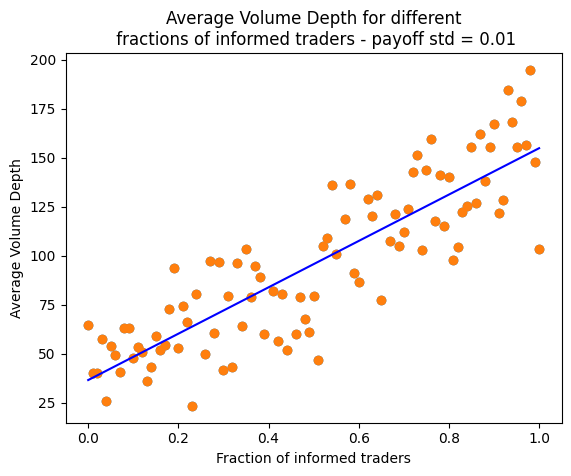

In [5]:
depth_inf_0_size = []
depth_inf_0_volumes = []
simulation_length = 1000

for fraction in tqdm(range(0,101)):
    try:
        f = fraction / 100
    # for std in range(1, 10):
        s = 0.01#std/100
        book, _, _ = simulate(
                        book=OrderBook(), 
                        fraction_of_informed_buyers=f, 
                        prob_seller=0.5, 
                        simulation_length=simulation_length, 
                        payoff_mean=10, 
                        payoff_std=s)

        depth_inf_0_size.append((f, book.depth_sequence_size))
        depth_inf_0_volumes.append((f, book.depth_sequence_volumes))
    except Exception:
        continue
    
# average sum of volume depends on the fraction of informed traders
bid_vol = []
f_list = []
for d in depth_inf_0_volumes:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y)
plt.xlabel('Fraction of informed traders')
plt.ylabel('Average Volume Depth')

plt.title(f'Average Volume Depth for different\n fractions of informed traders - payoff std = {s}')
plt.scatter(f_list, bid_vol)

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')


print(f"Depth mean: {np.mean(bid_vol)}")
print(f"Depth std: {np.std(bid_vol)}")

print("linear regression parameters")
print(results.params)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:27<00:00,  3.73it/s]


Depth mean: 140.73748426662422
Depth std: 36.139013834819664
linear regression parameters
[ 87.73139448 106.01217958]


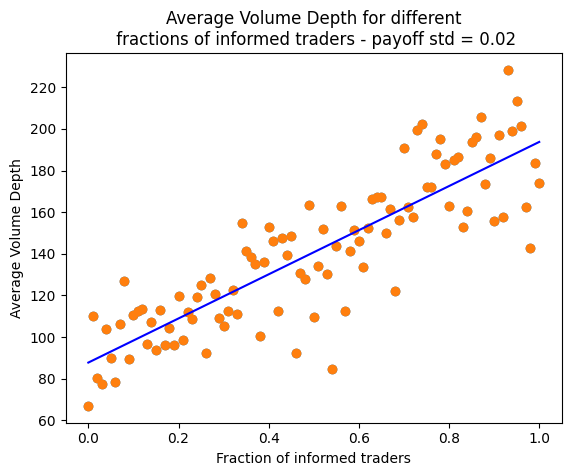

In [6]:
depth_inf_0_size = []
depth_inf_0_volumes = []
simulation_length = 1000

for fraction in tqdm(range(0,101)):
    try:
        f = fraction / 100
    # for std in range(1, 10):
        s = 0.02#std/100
        book, _, _ = simulate(
                        book=OrderBook(), 
                        fraction_of_informed_buyers=f, 
                        prob_seller=0.5, 
                        simulation_length=simulation_length, 
                        payoff_mean=10, 
                        payoff_std=s)

        depth_inf_0_size.append((f, book.depth_sequence_size))
        depth_inf_0_volumes.append((f, book.depth_sequence_volumes))
    except Exception:
        continue

# average sum of volume depends on the fraction of informed traders
bid_vol = []
f_list = []
for d in depth_inf_0_volumes:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y)
plt.xlabel('Fraction of informed traders')
plt.ylabel('Average Volume Depth')

plt.title(f'Average Volume Depth for different\n fractions of informed traders - payoff std = {s}')
plt.scatter(f_list, bid_vol)

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')


print(f"Depth mean: {np.mean(bid_vol)}")
print(f"Depth std: {np.std(bid_vol)}")

print("linear regression parameters")
print(results.params)

100%|██████████| 101/101 [00:30<00:00,  3.28it/s]


Depth mean: 156.71739454511922
Depth std: 41.562749222989446
linear regression parameters
[ 91.95558028 129.52362854]


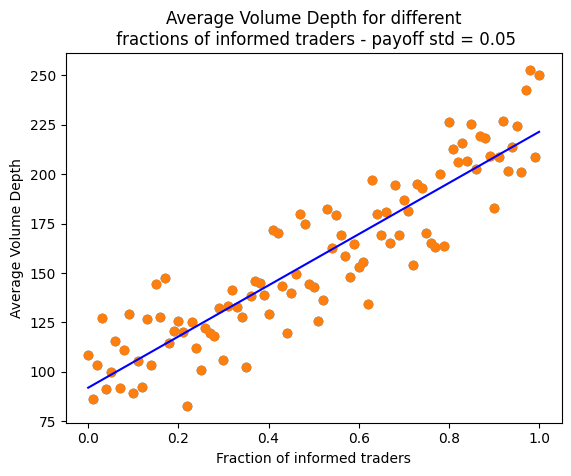

In [7]:
depth_inf_0_size = []
depth_inf_0_volumes = []
simulation_length = 1000

for fraction in tqdm(range(0,101)):
    try:
        f = fraction / 100
    # for std in range(1, 10):
        s = 0.05#std/100
        book, _, _ = simulate(
                        book=OrderBook(), 
                        fraction_of_informed_buyers=f, 
                        prob_seller=0.5, 
                        simulation_length=simulation_length, 
                        payoff_mean=10, 
                        payoff_std=s)

        depth_inf_0_size.append((f, book.depth_sequence_size))
        depth_inf_0_volumes.append((f, book.depth_sequence_volumes))
    except Exception:
        continue

# average sum of volume depends on the fraction of informed traders
bid_vol = []
f_list = []
for d in depth_inf_0_volumes:
    average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
    
    bid_vol.append(average_depth)

    f_list.append(d[0])

x = f_list
y = bid_vol
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

y_pred = results.predict(x)

plt.figure()

plt.scatter(x[:,1], y)
plt.xlabel('Fraction of informed traders')
plt.ylabel('Average Volume Depth')

plt.title(f'Average Volume Depth for different\n fractions of informed traders - payoff std = {s}')
plt.scatter(f_list, bid_vol)

plt.plot(x[:, 1], y_pred, color='blue', label='Linear Regression Line')


print(f"Depth mean: {np.mean(bid_vol)}")
print(f"Depth std: {np.std(bid_vol)}")

print("linear regression parameters")
print(results.params)

In [8]:
#y = [tpl[0] for tpl in depth_inf_0]
#x = list(range(1, len(depth_inf_0[0][1]) + 1))
#
#z = np.array([tpl[1] for tpl in depth_inf_0])
#
#fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='3d')
#
#X, Y = np.meshgrid(x, y)
#
#ax.plot_surface(X, Y, z, cmap='viridis')
#
#ax.set_xlabel('Snapshots')
#ax.set_ylabel('Std of payoff')
#ax.set_zlabel('Depth')
#
#ax.set_title('Order Book Depth')
#
#ax.view_init(elev=30, azim=-40)
#
#
#plt.show()